<font color="green">**LSTM model for drift detection and drift adaptation**</font>

**Import libraries**

In [ ]:
#Import the libraries
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

**Get stock data and visualize**

In [ ]:
#Get the stock quote 
df = web.DataReader('DIS', data_source='yahoo', start='2016-07-22', end='2020-10-30') 

#To get stock data for Apple, AMD, Tesla=>uncomment required line below
#df = web.DataReader('AAPL', data_source='yahoo', start='2016-07-22', end='2020-05-26')
#df = web.DataReader('AMD', data_source='yahoo', start='2016-07-22', end='2020-05-26')
#df = web.DataReader('TSLA', data_source='yahoo', start='2016-07-22', end='2020-05-26')

#Show the data 
df.head(5)

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2016-07-22,98.419998,97.470001,98.389999,97.709999,5381700.0,92.853477
2016-07-25,98.059998,97.250000,97.900002,97.389999,4825500.0,92.549377
2016-07-26,97.160004,96.339996,97.019997,96.690002,6274800.0,91.884163
2016-07-27,96.930000,95.860001,96.699997,96.330002,6911400.0,91.542076
2016-07-28,96.489998,95.820000,96.400002,95.910004,7713500.0,91.142944


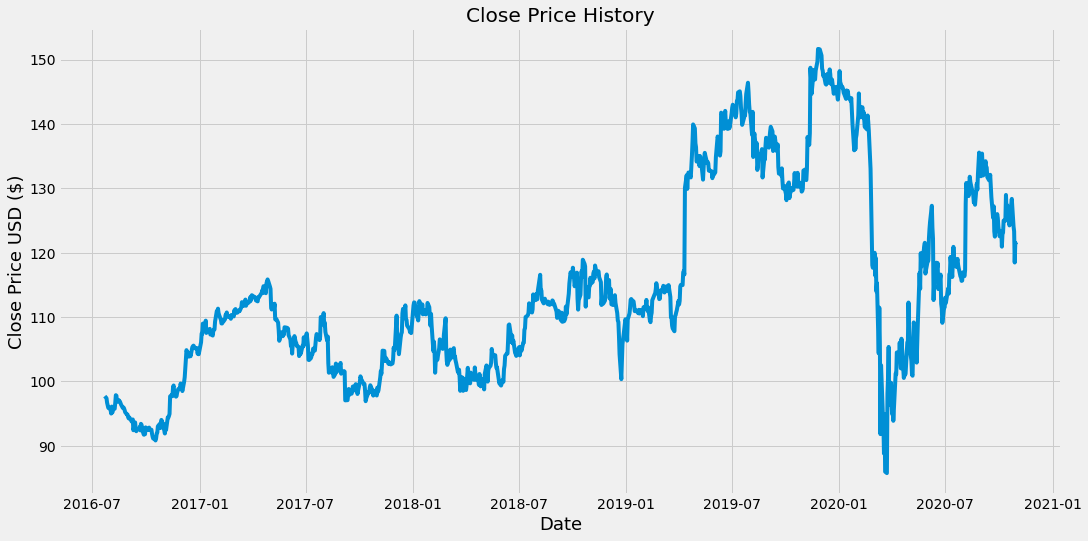

In [ ]:
#Visualize the closing price history
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price USD ($)',fontsize=18)
plt.show()

**Preprocess stock data and split into train-test datasets**

In [ ]:
#Create a new dataframe with only the 'Close' column
data = df.filter(['Close'])
#Converting the dataframe to a numpy array
dataset = data.values
#Get /Compute the number of rows to train the model on
training_data_len = math.ceil( len(dataset) *.8)

#Scale the all of the data to be values between 0 and 1 
scaler = MinMaxScaler(feature_range=(0, 1)) 
scaled_data = scaler.fit_transform(dataset)

In [ ]:
#Create the scaled training data set 
train_data = scaled_data[0:training_data_len  , : ]
#train_data = dataset[0:training_data_len  , : ]
#Split the data into x_train and y_train data sets
x_train=[]
y_train = []
for i in range(60,len(train_data)):
  x_train.append(train_data[i-60:i,0])
  y_train.append(train_data[i,0])

#Convert x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

In [ ]:
#Test data set
#scaled_data = scaler.fit_transform(dataset)
test_data = scaled_data[training_data_len - 60: , : ]
#data = df.filter(['Close'])
#Converting the dataframe to a numpy array
#dataset = data.values
#test_data = dataset[training_data_len - 60: , : ]
#test_data = scaler.fit_transform(test_data)
#Create the x_test and y_test data sets
x_test = []
y_test =  dataset[training_data_len : , : ] #Get all of the rows from index 1603 to the rest and all of the columns (in this case it's only column 'Close'), so 2003 - 1603 = 400 rows of data
for i in range(60,len(test_data)):
  x_test.append(test_data[i-60:i,0])


#Convert x_test to a numpy array 
x_test = np.array(x_test)

**Build model and train on training data**

In [ ]:
#Build the LSTM network model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True,input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=25))
model.add(Dense(units=1))

#Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')
#model.compile(optimizer='adam',loss='mean_absolute_error')

#Reshape the data into the shape accepted by the LSTM
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

#Train the model
#model.fit(x_train, y_train, batch_size=1, epochs=1)
model.fit(x_train,  y_train, batch_size=1, epochs=1)

803/803 [==============================] - 18s 22ms/step - loss: 0.0032


**Predict on testing data and visualize predictions**

In [ ]:
#Reshape the data into the shape accepted by the LSTM
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))

#Getting the models predicted price values
predictions = model.predict(x_test) 
preds=predictions
predictions = scaler.inverse_transform(predictions)#Undo scaling

#Calculate/Get the value of RMSE
rmse=np.sqrt(np.mean(((predictions- y_test)**2)))
rmse

4.769569070144372

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


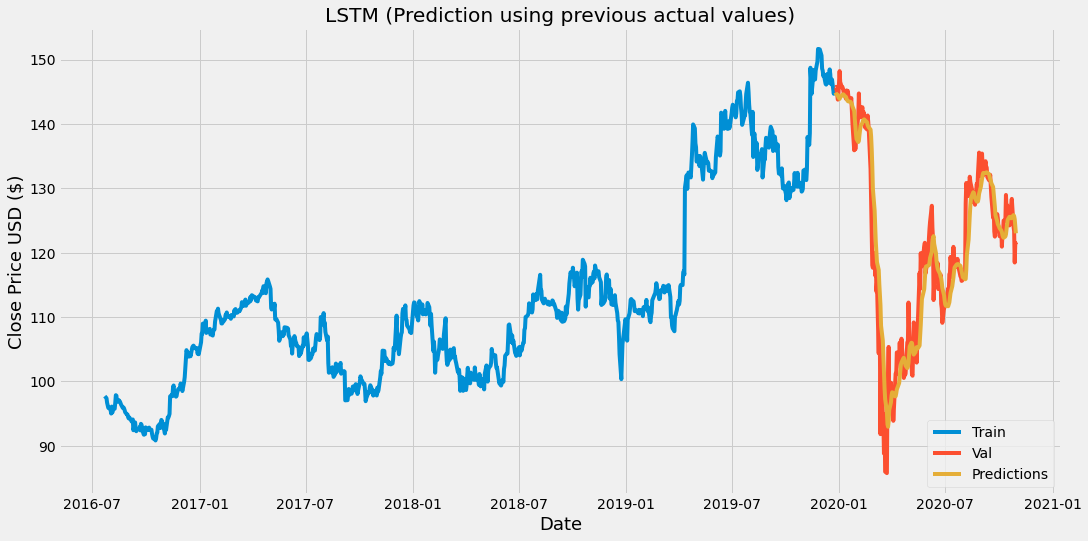

In [ ]:
#Plot/Create the data for the graph
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
#Visualize the data
plt.figure(figsize=(16,8))
plt.title('LSTM (Prediction using previous actual values)')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

<font color="green">**Drift detection**</font>

In [ ]:
#mean absolute error
from sklearn.metrics import mean_absolute_error
mae=mean_absolute_error(y_test, predictions)
mae

3.3564971568972566

In [ ]:
#Find drift data
df1=df.reset_index()
datelist=[]
for i in range(len(y_test)):
  diff=abs(y_test[i]-predictions[i])
  if(diff>(mae+5)):
    #print(df1.loc[training_data_len+i,"Date"])
    datelist.append(df1.loc[training_data_len+i,"Date"])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


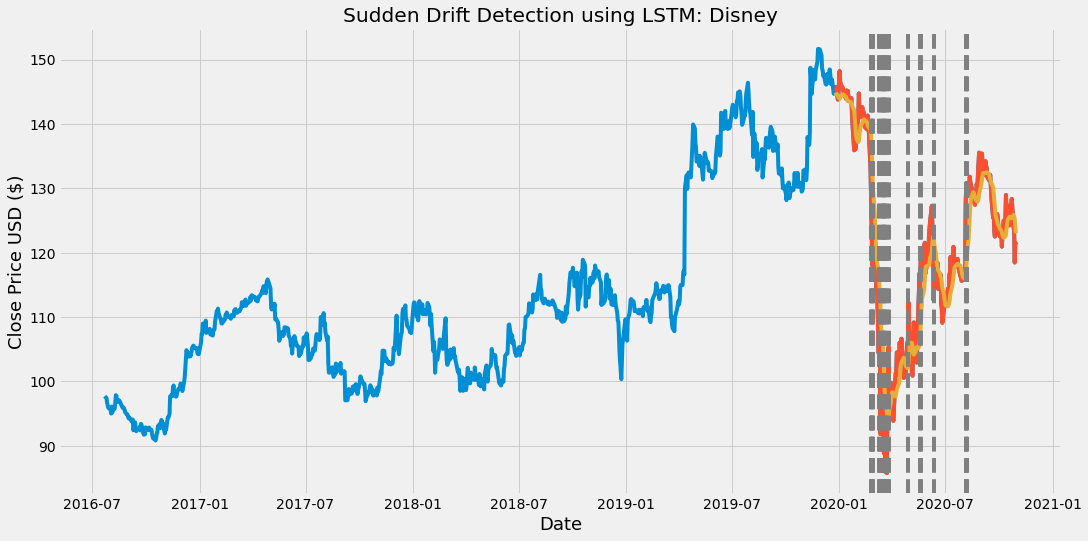

In [ ]:
#Plot data on graph
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
#Visualize the closing price history
plt.figure(figsize=(16,8))
plt.title('Sudden Drift Detection using LSTM: Disney')
plt.plot(df1['Date'],df1['Close'])
plt.plot(valid[['Close', 'Predictions']])
for i in range(len(datelist)):
  plt.axvline(pd.Timestamp(datelist[i]),color='gray',linestyle='--')
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price USD ($)',fontsize=18)
plt.show()

<font color="green">**Adaptive LSTM**</font>

**Get start and end date to determine new data for retraining model**

In [ ]:
startDate=datelist[0]
print(startDate)

2020-02-25 00:00:00


**Different retraining options:**

**1. Retrain using past data**(keep start date same as start date of training data and keep end date as first date in drift data)

**2. Retrain using drift data**(keep start date as first date in drift data and keep end date as last date in drift data)

**3. Retrain using past and current data**(keep start date same as start date of training data and keep end date as last date in drift data)

In [ ]:
#To retrain on past data=> keep start date same as start date of training data and keep end date as first date in drift data
#To retrain on drift data=> keep start date as first date in drift data and keep end date as last date in drift data
#To retrain on past and current data=> keep start date same as start date of training data and keep end date as last date in drift data

#Following code is for retraining using past and current data (start date same as start date of training data and keep end date as last date in drift data)

#Get the stock quote 
dfnew = web.DataReader('DIS', data_source='yahoo', start='2016-07-22', end='2020-10-30') 
#Show the data 
dfnew.head(5)

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2016-07-22,98.419998,97.470001,98.389999,97.709999,5381700.0,92.853477
2016-07-25,98.059998,97.250000,97.900002,97.389999,4825500.0,92.549377
2016-07-26,97.160004,96.339996,97.019997,96.690002,6274800.0,91.884163
2016-07-27,96.930000,95.860001,96.699997,96.330002,6911400.0,91.542076
2016-07-28,96.489998,95.820000,96.400002,95.910004,7713500.0,91.142944


**Preprocess data and split into train-test datasets**

In [ ]:
#Create a new dataframe with only the 'Close' column
data = df.filter(['Close'])
datanew = dfnew.filter(['Close'])
#Converting the dataframe to a numpy array
dataset = data.values
datasetnew = datanew.values
#Get /Compute the number of rows to train the model on
training_data_len = math.ceil( len(dataset) *.8)
training_data_len_new = math.ceil( len(datasetnew)*1)

#Scale the all of the data to be values between 0 and 1 
scaler = MinMaxScaler(feature_range=(0, 1)) 
scaled_data = scaler.fit_transform(dataset)
scaled_data_new = scaler.fit_transform(datasetnew)

In [ ]:
#Create the scaled training data set 
train_data = scaled_data[0:training_data_len  , : ]
train_data_new = scaled_data_new[0:training_data_len_new  , : ]
#train_data = dataset[0:training_data_len  , : ]
#Split the data into x_train and y_train data sets
x_train=[]
y_train = []
for i in range(60,len(train_data)):
  x_train.append(train_data[i-60:i,0])
  y_train.append(train_data[i,0])

x_train_new=[]
y_train_new = []
for i in range(60,len(train_data_new)):
  x_train_new.append(train_data_new[i-60:i,0])
  y_train_new.append(train_data_new[i,0])

#Convert x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

x_train_new, y_train_new = np.array(x_train_new), np.array(y_train_new)

In [ ]:
#Test data set
#scaled_data = scaler.fit_transform(dataset)
test_data = scaled_data[training_data_len - 60: , : ]
#data = df.filter(['Close'])
#Converting the dataframe to a numpy array
#dataset = data.values
#test_data = dataset[training_data_len - 60: , : ]
#test_data = scaler.fit_transform(test_data)
#Create the x_test and y_test data sets
x_test = []
y_test =  dataset[training_data_len : , : ] #Get all of the rows from index 1603 to the rest and all of the columns (in this case it's only column 'Close'), so 2003 - 1603 = 400 rows of data
for i in range(60,len(test_data)):
  x_test.append(test_data[i-60:i,0])


#Convert x_test to a numpy array 
x_test = np.array(x_test)

**Build model and retrain on new training data**

In [ ]:
#Build the LSTM network model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True,input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=25))
model.add(Dense(units=1))

#Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')
#model.compile(optimizer='adam',loss='mean_absolute_error')

#Reshape the data into the shape accepted by the LSTM
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))
x_train_new = np.reshape(x_train_new, (x_train_new.shape[0],x_train_new.shape[1],1))

#Train the model
#model.fit(x_train, y_train, batch_size=1, epochs=1)
model.fit(x_train_new,  y_train_new, batch_size=1, epochs=1)

1018/1018 [==============================] - 22s 22ms/step - loss: 0.0047


**Predict on new testing data and visualize**

In [ ]:
#Reshape the data into the shape accepted by the LSTM
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))

#Getting the models predicted price values
predictions = model.predict(x_test) 
preds=predictions
predictions = scaler.inverse_transform(predictions)#Undo scaling

#Calculate/Get the value of RMSE
rmse=np.sqrt(np.mean(((predictions- y_test)**2)))
rmse

4.376953340168568

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


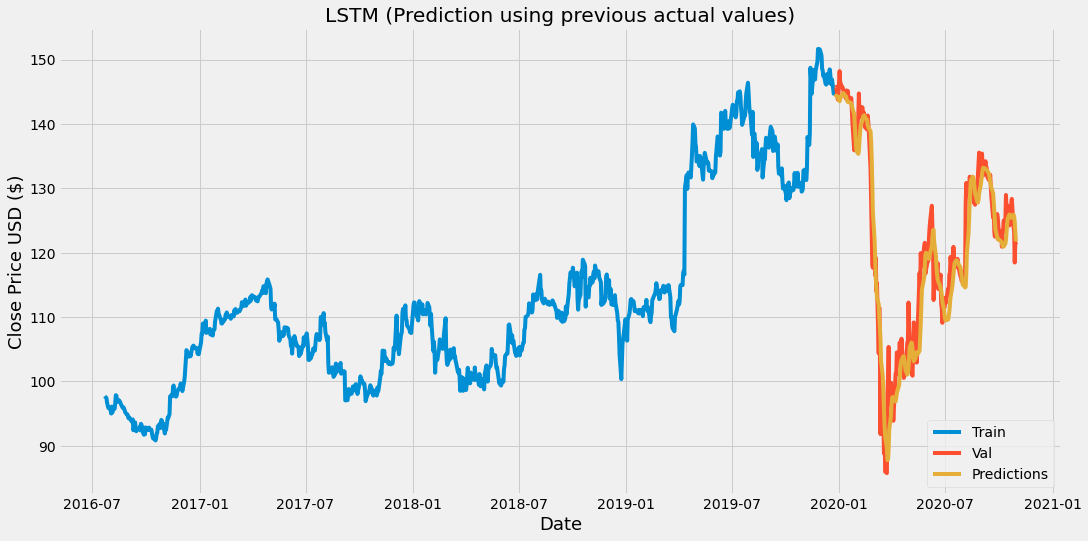

In [ ]:
#Plot/Create the data for the graph
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
#Visualize the data
plt.figure(figsize=(16,8))
plt.title('LSTM (Prediction using previous actual values)')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

**Drift detection after retraining model**

In [ ]:
#mean absolute error
from sklearn.metrics import mean_absolute_error
mae=mean_absolute_error(y_test, predictions)
mae

3.1548057023869003

In [ ]:
#Find new drift data
df1=df.reset_index()
datelist=[]
for i in range(len(y_test)):
  diff=abs(y_test[i]-predictions[i])
  if(diff>(mae+10)):
    #print(df1.loc[training_data_len+i,"Date"])
    datelist.append(df1.loc[training_data_len+i,"Date"])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


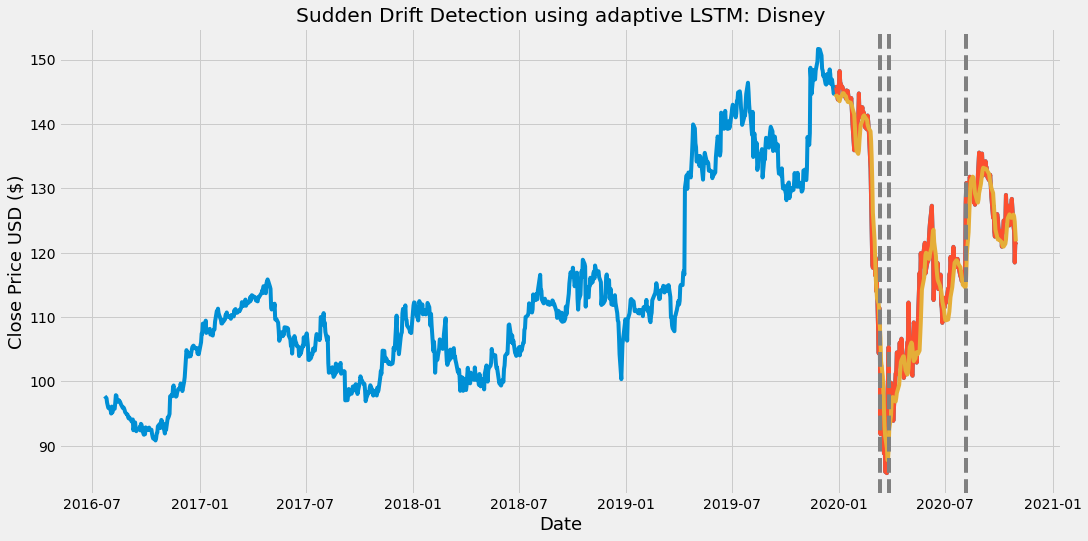

In [ ]:
#Plot new data on graph
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
#Visualize the closing price history
plt.figure(figsize=(16,8))
plt.title('Sudden Drift Detection using adaptive LSTM: Disney')
plt.plot(df1['Date'],df1['Close'])
plt.plot(valid[['Close', 'Predictions']])
for i in range(len(datelist)):
  plt.axvline(pd.Timestamp(datelist[i]),color='gray',linestyle='--')
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price USD ($)',fontsize=18)
plt.show()